# 466 final project

### What we want 

we want to be able to take a set of users and use their previous transactions to predict what dapps they will use in the future.

## Load and clean user account data
these users will be split up into training and testing sets
this list of users was pulled from pontem's space pirate whitelist.
Pontem is a dapp that allows users to earn 'interest' on their crypto holdings by providing liquidity through their dex (sets of liquidity pools).

In [2]:
import pandas as pd
#load the users csv file (
users = open('users.csv').readlines()
user_temp = []
for user in users:
    if len(user)>=66:
        user_temp.append(user.split(',')[0])
print("ALL user ADDR COUNT:",len(users))
users = user_temp

print("PROPPER ADDR COUNT:",len(users))



ALL user ADDR COUNT: 31622
PROPPER ADDR COUNT: 31622


We also need to load in the information about the dapps that we want to predict for. We will use the dapp list created by 'seam-money' an explorer for dapps on the network

In [3]:
dapps = open('dapps.csv').readlines()
# print(dapps)
dapp_dic = {}
dapp_types = {}
for dapp in dapps:
    d = dapp.split(',')
    dapp_dic[d[0]] = d[1]
    dapp_types[d[1]] = dapp_types.get(d[-1])
print("DAPP COUNT:",len(dapp_dic))
print("DAPP TYPES:",len(dapp_types))
print(dapp_dic)
print(dapp_dic.values())

DAPP COUNT: 12
DAPP TYPES: 12
{'0x62fdfe47c9c37227be1f885e79be827be292fe1833ac63a2fe2c2c16c55ecb12': 'KanaLabs', '0xd1fd99c1944b84d1670a2536417e997864ad12303d19eac725891691b04d614e': 'BlueMove', '0x89576037b3cc0b89645ea393a47787bb348272c76d6941c574b053672b848039': 'Hippo-Labs', '0x2c7bccf7b31baf770fdbcc768d9e9cb3d87805e255355df5db32ac9a669010a2': 'Souffl3', '0x9770fa9c725cbd97eb50b2be5f7416efdfd1f1554beb0750d4dae4c64e860da3': 'Aries', '0x190d44266241744264b964a37b8f09863167a12d3e70cda39376cfb4e3561e12': 'liquidSwap', '0x16fe2df00ea7dde4a63409201f7f4e536bde7bb7335526a35d05111e68aa322c': 'AnimeSwap', '0xd4c70815e9d245a097646af821ecf87a073039e71e93c8cd04a0da082134d296': 'Topaz', '0x98298d34bcf896c663e069c464754e0cfd36b50e21eedd8db0e4189168057cb7': 'Argo', '0x7ab72b249ec24f76fe66b6de19dcee1e3d3361db5c2cccfaa48ea8659060a1bd': 'HoustonSwap', '0xec42a352cc65eca17a9fa85d0fc602295897ed6b8b8af6a6c79ef490eb8f9eba': 'Cetus', '0xbd35135844473187163ca197ca93b2ab014370587bb0ed3befff9e902d6bb541': 'Au

In [ ]:
users[0]

'0x9ee9892d8600ed0bf65173d801ab75204a16ac2c6f190454a3b98f6bcb99d915'

In [4]:
# from flask import jsonify
import requests
import random
NODE_URL = "https://fullnode.mainnet.aptoslabs.com/v1"
def get_account_transactions(address):
    user_dapps = {}
    response = requests.get(
        f"{NODE_URL}/accounts/{address}/transactions",
        params={"limit": 50}
        )
    try:
        resources = requests.get(
            f"{NODE_URL}/accounts/{address}/resource/0x1::coin::CoinStore<0x1::aptos_coin::AptosCoin>",
            )
        resources=resources.json()
        user_dapps["balance"] = int(dict(resources)['data']['coin']['value'])/100000000
    except:
        pass

    txs = response.json()
    txns_temp = []
    for tx in txs:
        try:
            txn = {}
            payload = tx['payload']
            to = payload['function'].split('::')[0]
            func = payload['function'].split('::')[2]
            mod = payload['function'].split('::')[1]
            txn['function'] = func
            txn['module'] = mod
            if to in dapp_dic.keys():
                dapp_name = dapp_dic[to]
                if dapp_name in user_dapps.keys():
                    user_dapps[dapp_name] = 1 + user_dapps[dapp_name]
                else:
                    user_dapps[dapp_name] = 1
            txns_temp.append(txn)
        except:
            pass
    return txns_temp,user_dapps

def find_dapps_used(address):
    transactions,dapps = get_account_transactions(address)
    return dapps

users_used_dapps = {}
# demo_users = random.sample(users, 100)
for user in users[:20]:
    # print("USER:",user)
    dapps = find_dapps_used(user)
    if len(dapps.keys())>1 and "balance" in dapps.keys():
        users_used_dapps[user] = dapps
        print(users_used_dapps[user])



{'balance': 8.56309932, 'AnimeSwap': 1, 'KanaLabs': 1, 'Hippo-Labs': 4, 'Souffl3': 4, 'Aux': 2, 'BlueMove': 1}
{'balance': 0.50684493, 'AnimeSwap': 11}
{'balance': 0.86770361, 'BlueMove': 4, 'liquidSwap': 1, 'Souffl3': 2, 'AnimeSwap': 6}
{'balance': 1.48933719, 'Souffl3': 11, 'liquidSwap': 1}
{'balance': 0.08850767, 'Cetus': 2, 'Souffl3': 11}
{'balance': 0.32171948, 'AnimeSwap': 2, 'liquidSwap': 1, 'Aux': 2, 'Souffl3': 4}
{'balance': 1.69949497, 'BlueMove': 2, 'Souffl3': 2}
{'balance': 0.02974254, 'Souffl3': 3, 'BlueMove': 5, 'Topaz': 1}
{'balance': 0.3736268, 'Souffl3': 15, 'AnimeSwap': 5}


In [1]:



# for user in users[:2000]:
#     # print("USER:",user)
#     dapps = find_dapps_used(user)
#     if len(dapps.keys())>1 and "balance" in dapps.keys():
#         users_used_dapps[user] = dapps
#         print(users_used_dapps[user])


NameError: name 'random' is not defined

In [7]:
# now we want this dic as a list and to sort it by highest balance
user_ls = list(users_used_dapps.values())
sorted_list = sorted(user_ls, key=lambda x: float(x["balance"]))
print(sorted_list[-1])

{'balance': 599.75241229, 'liquidSwap': 2}


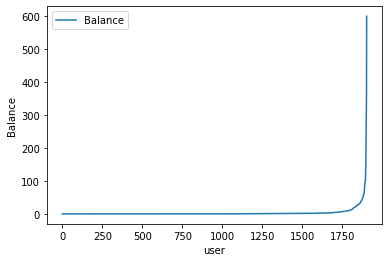

In [9]:
from matplotlib import pyplot as plt
import pandas as pd
balances = [float(t['balance']) for t in sorted_list]
users = [i for i in range(len(sorted_list))]

plt.plot(balances)
plt.legend(labels=['Balance'])
plt.xlabel("user")
plt.ylabel("Balance")

plt.show()

In [10]:
# num_bins = 4
# n, bins, patches = plt.hist(balances, num_bins, facecolor='blue',alpha=0.9)
# plt.show()
dapp_ls = dapp_dic.values()
print(dapp_ls)

dict_values(['KanaLabs', 'BlueMove', 'Hippo-Labs', 'Souffl3', 'Aries', 'liquidSwap', 'AnimeSwap', 'Topaz', 'Argo', 'HoustonSwap', 'Cetus', 'Aux'])


In [11]:
# find the portion of users that use each dapp
def dapp_usage(dapp,users):
    count = 0
    for user in users.values():
        if dapp in user.keys():
            count += 1
    return count/len(users.keys())
dapp_probs = {}
for dapp in dapp_ls:
    dapp_probs[dapp] = dapp_usage(dapp,users_used_dapps)

def count_uses_both(dappa,dappb,users_used_dapps):
    count = 0
    total = 0
    for user in users_used_dapps.values():
        if dappa in user.keys() and dappb in user.keys():
            count += 1
        if dappa in user.keys():
            total += 1
    if total == 0:
        return 0
    return count/total
# given user uses Bdapp, what is the probability they use Adapp
def conditional_prob(A,B,dapp_probs):
    # pA = dapp_probs[A]
    pB = dapp_probs[B]
    pAB = count_uses_both(A,B,users_used_dapps)*dapp_probs[A]
    if pB == 0:
        return 0
    return pAB/pB
print(dapp_probs)

# find the conditional probability of using a dapp given that you use another dapp

def print_prob(A,B,probs):
    print("given that you use",B,"the probability you use",A,"is",probs)

print(conditional_prob("KanaLabs","Souffl3",dapp_probs))
prob_dic = {}
for dapp in dapp_ls:
    for dapp2 in dapp_ls:
        if dapp != dapp2:
            prob_A_given_B = conditional_prob(dapp,dapp2,dapp_probs)
            print_prob(dapp,dapp2,prob_A_given_B)
            prob_dic[dapp+"|"+dapp2] = prob_A_given_B


{'KanaLabs': 0.1111111111111111, 'BlueMove': 0.4444444444444444, 'Hippo-Labs': 0.1111111111111111, 'Souffl3': 0.8888888888888888, 'Aries': 0.0, 'liquidSwap': 0.3333333333333333, 'AnimeSwap': 0.5555555555555556, 'Topaz': 0.1111111111111111, 'Argo': 0.0, 'HoustonSwap': 0.0, 'Cetus': 0.1111111111111111, 'Aux': 0.2222222222222222}
0.125
given that you use BlueMove the probability you use KanaLabs is 0.25
given that you use Hippo-Labs the probability you use KanaLabs is 1.0
given that you use Souffl3 the probability you use KanaLabs is 0.125
given that you use Aries the probability you use KanaLabs is 0
given that you use liquidSwap the probability you use KanaLabs is 0.0
given that you use AnimeSwap the probability you use KanaLabs is 0.19999999999999998
given that you use Topaz the probability you use KanaLabs is 0.0
given that you use Argo the probability you use KanaLabs is 0
given that you use HoustonSwap the probability you use KanaLabs is 0
given that you use Cetus the probability yo

In [16]:
#  find the most related dapps
high_probs = []
for dapp_prob in prob_dic.keys():
  if dapp_prob not in dapp_ls:
    high_probs.append((dapp_prob,prob_dic[dapp_prob]))

high_probs = sorted(high_probs, key=lambda x: float(x[1]))
# print(high_probs[-10:])

for prob in high_probs[-15:]:
  print(prob)

# reverse high probs


def highest_given(dapp):
  highest = 0
  highest_dapp = ""
  for dapp_prob in high_probs:
    sp = dapp_prob[0].split("|")
    if len(sp)>1 and sp[1] == dapp:
      print('found')
      return sp[0]

with_hippo = highest_given("Hippo-Labs")
print(with_hippo)


('BlueMove|Hippo-Labs', 1.0)
('BlueMove|Topaz', 1.0)
('Hippo-Labs|KanaLabs', 1.0)
('Souffl3|KanaLabs', 1.0)
('Souffl3|BlueMove', 1.0)
('Souffl3|Hippo-Labs', 1.0)
('Souffl3|liquidSwap', 1.0)
('Souffl3|Topaz', 1.0)
('Souffl3|Cetus', 1.0)
('Souffl3|Aux', 1.0)
('Aux|KanaLabs', 1.0)
('Aux|Hippo-Labs', 1.0)
('AnimeSwap|KanaLabs', 1.0000000000000002)
('AnimeSwap|Hippo-Labs', 1.0000000000000002)
('AnimeSwap|Aux', 1.0000000000000002)
found
Aries


In [17]:
import random

def get_test_users(n):
    return random.sample(users, n)

def get_test_users_dapps(n):
    test_users = get_test_users(n)
    users_dapps = {}
    for user in test_users:
        dapps = find_dapps_used(user)
        if len(dapps.keys())>1 and "balance" in dapps.keys():
            users_dapps[user] = dapps
    return users_dapps

test_users_dapps = get_test_users_dapps(10)
print(test_users_dapps)
most_used_per_user = {}
for user in test_users_dapps.keys():
    most_used_per_user[user] = max(test_users_dapps[user], key=test_users_dapps[user].get)
print(most_used_per_user)

# for each most used dapp find the other dapps that are most likely to be used
for user in most_used_per_user.keys():
    dapp = most_used_per_user[user]
    for dapp2 in dapp_ls:
        if dapp != dapp2:
            prob_A_given_B = conditional_prob(dapp,dapp2,dapp_probs)
            print_prob(dapp,dapp2,prob_A_given_B)
            prob_dic[dapp+"|"+dapp2] = prob_A_given_B
    


In [34]:
pd.DataFrame.from_dict(prob_dic,orient="index")

,0
KanaLabs|BlueMove,0.038023
KanaLabs|Hippo-Labs,0.022556
KanaLabs|Souffl3,0.023121
KanaLabs|Aries,0.028986
KanaLabs|liquidSwap,0.017011
...,...
Aux|AnimeSwap,0.281250
Aux|Topaz,0.068120
Aux|Argo,0.346774
Aux|HoustonSwap,0.230769


In [29]:
liquid_users = 95600
hippo_users = 28000

user_count_by_dapp = {
    "liquidSwap": liquid_users,
}
for ab in prob_dic.keys():
    A,B = ab.split("|")
    if B == "liquidSwap":
        prob = prob_dic[ab]
        user_count_by_dapp[A] = liquid_users*prob
print(user_count_by_dapp)
for ab in prob_dic.keys():
    A,B = ab.split("|")
    if B == "Hippo-Labs":
        prob = prob_dic[ab]
        user_count_by_dapp[A] = liquid_users*prob


    # user_count_by_dapp[A] += prob_dic[ab]*user_count_by_dapp[B]

print(user_count_by_dapp)

{'liquidSwap': 95600, 'KanaLabs': 1626.2454434993926, 'BlueMove': 10512.51518833536, 'Hippo-Labs': 24974.48359659781, 'Souffl3': 40191.49453219927, 'Aries': 3020.170109356015, 'AnimeSwap': 10105.953827460511, 'Topaz': 16378.614823815311, 'Argo': 5982.260024301338, 'HoustonSwap': 522.7217496962332, 'Cetus': 8015.066828675576, 'Aux': 9699.392466585663}
{'liquidSwap': 77270.67669172931, 'KanaLabs': 2156.3909774436092, 'BlueMove': 13297.74436090226, 'Hippo-Labs': 24974.48359659781, 'Souffl3': 38994.73684210526, 'Aries': 8086.466165413534, 'AnimeSwap': 18688.721804511282, 'Topaz': 16712.030075187973, 'Argo': 13297.744360902258, 'HoustonSwap': 898.4962406015039, 'Cetus': 14735.33834586466, 'Aux': 17610.526315789477}


In [ ]:
def avg_dapps_used(users_used_dapps):
    total = 0
    for user in users_used_dapps.keys():
        total += len(users_used_dapps[user].keys())
    return total/len(users_used_dapps.keys())

avg_dapps_by_user = avg_dapps_used(users_used_dapps)
print("AVG DAPPS USED BY USER:",avg_dapps_by_user)


AVG DAPPS USED BY USER: 3.5254237288135593


In [ ]:
def avg_txns_per_dapp(users_used_dapps):
    totals = {}
    for user in users_used_dapps.keys():
        for dapp in users_used_dapps[user].keys():
            if dapp in totals.keys():
                totals[dapp] += users_used_dapps[user][dapp]
            else:
                totals[dapp] = users_used_dapps[user][dapp]
    print(totals)
    return totals

totals = avg_txns_per_dapp(users_used_dapps)

{'balance': 29.48971122, 'BlueMove': 16, 'AnimeSwap': 34, 'KanaLabs': 1, 'Hippo-Labs': 8, 'Souffl3': 66, 'liquidSwap': 31, 'Cetus': 2, 'Topaz': 3, 'Aries': 2}


In [17]:
#  use k-means to cluster the users based on the dapps they use
#  use the clusters to find the most popular dapps in each cluster
dapp_ls = dapp_dic.values()
def dapp_diff(user1,user2):
    diff_dic = {}
    for dapp in dapp_ls:
        if dapp in user1.keys() and dapp in user2.keys():
            diff_dic[dapp] = abs(user1[dapp]-user2[dapp])
        elif dapp in user1.keys() and dapp not in user2.keys():
            diff_dic[dapp] = user1[dapp]
        elif dapp not in user1.keys() and dapp in user2.keys():
            diff_dic[dapp] = user2[dapp]
        else:
            pass
    print(diff_dic)
    return diff_dic
user_addrs = list(users_used_dapps.keys())
user1 = users_used_dapps[user_addrs[0]]
print(user1)
user2 = users_used_dapps[user_addrs[1]]
print(user2)
dapp_diff(user1,user2)


{'balance': 8.56309932, 'AnimeSwap': 1, 'KanaLabs': 1, 'Hippo-Labs': 4, 'Souffl3': 4, 'Aux': 2, 'BlueMove': 1}
{'balance': 0.50684493, 'AnimeSwap': 11}
{'KanaLabs': 1, 'BlueMove': 1, 'Hippo-Labs': 4, 'Souffl3': 4, 'AnimeSwap': 10, 'Aux': 2}


{'KanaLabs': 1,
 'BlueMove': 1,
 'Hippo-Labs': 4,
 'Souffl3': 4,
 'AnimeSwap': 10,
 'Aux': 2}

In [ ]:
# determine if the user is a degen
def count_degens(users_used_dapps):
    degen_count = 0
    for user in users_used_dapps.values():
        if len(user)>3:
            degen_count += 1
    return degen_count

degen_count = count_degens(users_used_dapps)
print("DEGEN COUNT:",degen_count)

# print()
d_keys = list(dapp_dic.values())
d_mat = []

for user in list(users_used_dapps.values())[:2]:
  # show the dapps they used
  d_entry = [0 for dapp in d_keys]
  dapps = user.keys()
  i=0
  for key in d_keys:
    if key in dapps:
      d_entry[i]=1
    i+=1

    

DEGEN COUNT: 6


TypeError: ignored

In [19]:
# determine if the user if a whale/bigshark
def isWhale(user_dic):
  if user_dic['balance'] > 1:
    return "Yes"
  return "No"


In [ ]:
# use dapp_diff to compute the distance between each user
def user_distance(user1,user2):
    diff_dic = dapp_diff(user1,user2)
    total = 0
    for dapp in diff_dic.keys():
        total += diff_dic[dapp]
    return total
d = user_distance(user1,user2)
print(d)

{'KanaLabs': 1, 'BlueMove': 1, 'Hippo-Labs': 4, 'Souffl3': 4, 'AnimeSwap': 10}
20


In [20]:
# create a text file to represent the apps the users use
with open("user_dapps.txt", "w") as output:
    dapp_names = list(dapp_dic.values())
    output.write(" ".join(dapp_names)+ " Big_Shark" +"\n")
    for user in users_used_dapps.values():
        isshark = isWhale(user)
        for dapp_name in dapp_names:
          dapp_postfix = dapp_name[0] + dapp_name[-1]
          if dapp_name in user.keys():
              user_txs = user[dapp_name]
              if(user_txs>=5):
                output.write("H-"+dapp_postfix+" ")
              elif(user_txs>2):
                output.write("M-"+dapp_postfix+" ")
              elif(user_txs>0):
                output.write("L-"+dapp_postfix+" ")

          else:
              output.write("N-"+dapp_postfix+" ")
        output.write(isshark)
        output.write("\n")

In [ ]:
FLASK_URL = "localhost:5000"